## Get measurements

In [6]:
import pickle
from copy import deepcopy

from collections import defaultdict

anchors_file = "../datasets/anchors.pickle"
anchors_measurement_file = "../results/anchors_to_anchors_measurements.pickle"

with open(anchors_file, "rb") as f:
    anchors = pickle.load(f)

# load already existing measurements
with open(anchors_measurement_file, "rb") as f:
    anchor_measurements = pickle.load(f)


# sfor debugging, print some results
filtered_results = deepcopy(anchor_measurements)
for i, anchor in enumerate(filtered_results):
    if i > 10: break
    print(f"target ip: {anchor}, number of measurements: {len(anchor_measurements[anchor]['result'][0])}")
    
with open(anchors_measurement_file, "wb") as f:
    pickle.dump(anchor_measurements, f)

target ip: 129.13.73.54, number of measurements: 775
target ip: 152.195.112.52, number of measurements: 775
target ip: 193.46.104.17, number of measurements: 772
target ip: 200.3.170.54, number of measurements: 775
target ip: 195.30.70.33, number of measurements: 775
target ip: 86.38.3.141, number of measurements: 769
target ip: 77.110.218.255, number of measurements: 774
target ip: 156.154.135.254, number of measurements: 772
target ip: 34.89.240.90, number of measurements: 766
target ip: 34.68.239.153, number of measurements: 767
target ip: 195.130.66.103, number of measurements: 774


## select dataset

In [39]:
from random import choice

NB_TARGET = 2_00 # testing
NB_VP = 1 # testing

# select targets and vps from anchors
targets= [choice(list(anchor_measurements)) for _ in range(0, NB_TARGET)]
vps = list(set(anchor_measurements).difference(set(targets)))

analysis_dataset = {}
for i, target_addr in enumerate(targets):

    # select measurement where source is in vps
    measurement_results = []
    for result in anchor_measurements[target_addr]['result'][0]:

        if result['node'] in vps:
            measurement_results.append(result)
        
    analysis_dataset[target_addr] = measurement_results

## analyze data

In [40]:
from pathlib import Path
import pickle
from copy import copy

from geoloc_imc_2023.helpers import polygon_centroid, haversine, circle_intersections
from geoloc_imc_2023.draw_results import draw_results

def select_best_guess_centroid(target_addr, measurement_results):
    """
    Find the best guess
    that is the location of the vantage point closest to the centroid.
    """
    probe_circles = {}
    print(f"NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: {target_addr} : {len(measurement_results)}")
    for _, result in enumerate(measurement_results):
        vp_ip = result["node"]
        lat = result["vp_lat"]
        lon = result["vp_lon"]
        min_rtt = result["min_rtt"]

        # too inflated RTT means that measurement will not provide usefull info
        if isinstance(min_rtt, float):
                probe_circles[vp_ip] = (
                    lat,
                    lon,
                    min_rtt,
                    None,
                    None,
                )
                # print(f"vp_anchor = {vp_ip} with results: {min_rtt}")
    # print()

    # draw circles
    if not probe_circles: return

    intersections = circle_intersections(probe_circles.values(), speed_threshold=4/9)
    #print("intersecion:", intersections)
    target = (anchors[target_addr]["latitude"], anchors[target_addr]["longitude"])

    centroid = None
    if intersections:
        centroid = polygon_centroid(intersections)
        #print("centroid:", centroid)
        target_description = anchors[target_addr]

        if centroid:
            for ip_src, circle in probe_circles.items():

                measured_d = haversine((circle[0], circle[1]), centroid)
                calculated_d = haversine((target_description["latitude"], target_description["longitude"]), centroid)

                #print("ip_src:",ip_src,"dst (measured):", measured_d, "dst (calculated):", calculated_d)
    
    # draw_results(copy(probe_circles), intersections,centroid, target)

    return centroid

anchor_file = "../datasets/anchors.pickle"
with open(anchor_file, "rb") as f:
    anchors = pickle.load(f)

geoloc_results_subset_vps = {}
geoloc_results_all_vps = {}
nb_vps = 10
for i, target_addr in enumerate(analysis_dataset):

    print("available measurements for ip:",len(analysis_dataset[target_addr]))

    subset_vps = analysis_dataset[target_addr][:nb_vps]
    all_vps = analysis_dataset[target_addr]

    centroid = select_best_guess_centroid(target_addr, subset_vps)
    if centroid:
        geoloc_results_subset_vps[target_addr] = {
            "estimated_lat": centroid[0],
            "estimated_lon": centroid[1],
        }

    centroid = select_best_guess_centroid(target_addr, all_vps)
    if centroid:
        geoloc_results_all_vps[target_addr] = {
            "estimated_lat": centroid[0],
            "estimated_lon": centroid[1],
        }

available measurements for ip: 597
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 23.157.112.121 : 10
2 circles, case is not handled yet
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 23.157.112.121 : 597
2 circles, case is not handled yet
available measurements for ip: 599
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 141.98.136.85 : 10
only one circle found with coordinates: (50.1385, 8.7385, 0.37118, 49.49066666666667, 0.007768115942028986)
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 141.98.136.85 : 599
2 circles, case is not handled yet
available measurements for ip: 601
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 139.180.132.31 : 10
2 circles, case is not handled yet
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 139.180.132.31 : 601
2 circles, case is not handled yet
available measurements for ip: 601
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 109.168.125.243 : 10
2 circles, case is not handled yet
NUMBER OF MEASUREMENT RESULTS FOR TARGET IP: 109.168.125.243 : 601
2 circles, case is

In [46]:
print(len(geoloc_results_all_vps))
print(len(geoloc_results_subset_vps))

128
129


In [47]:
geoloc_out_file_subset_vps = Path(".") / "../results/all_anchors_towards_all_anchors_geoloc_subset.pickle"
with open(geoloc_out_file_subset_vps, "wb") as f:
    pickle.dump(geoloc_results_subset_vps, f)

geoloc_out_file_all_vps = Path(".") / "../results/all_anchors_towards_all_anchors_geoloc_all.pickle"
with open(geoloc_out_file_all_vps, "wb") as f:
    pickle.dump(geoloc_results_all_vps, f)

## output metrics

In [50]:
from geoloc_imc_2023.helpers import distance

geoloc_out_file_subset = Path(".") / "../results/all_anchors_towards_all_anchors_geoloc_subset.pickle"
with open(geoloc_out_file_subset, "rb") as f:
    geoloc_results_subset = pickle.load(f)

geoloc_out_file_all = Path(".") / "../results/all_anchors_towards_all_anchors_geoloc_all.pickle"
with open(geoloc_out_file_all, "rb") as f:
    geoloc_results_all = pickle.load(f)


def get_distance_error(geoloc_results) -> dict:
    """from a set of target ip and estimated distance return error distanvce"""
    d_error = {}
    for i, target_addr in enumerate(geoloc_results):
    
        target_lat = anchors[target_addr]["latitude"]
        target_lon = anchors[target_addr]["longitude"]

        estimated_lat = geoloc_results[target_addr]["estimated_lat"]
        estimated_lon = geoloc_results[target_addr]["estimated_lon"]

        d_error[target_addr] = distance(target_lat, estimated_lat, target_lon, estimated_lon)

    return d_error

d_error_subset = get_distance_error(geoloc_results_subset)
d_error_all = get_distance_error(geoloc_results_all)

129
128


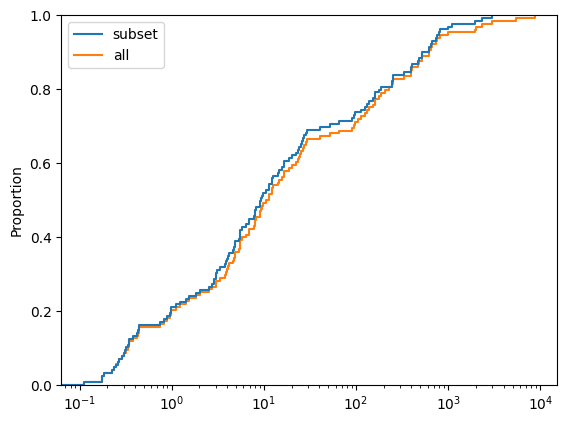

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt


data = {
    "subset" : d_error_subset,
    "all": d_error_all
}

cdf_d_error = sns.ecdfplot(data)
plt.xscale('log')
plt.show()